In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
base_path = '/content/drive/MyDrive/steganalysis'
clean_path = os.path.join(base_path, 'clean')
stego_path = os.path.join(base_path, 'stego')

In [5]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import cv2

In [6]:
def preprocess_images(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (512, 512))  # Resize to 512x512
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    return image.flatten()

In [7]:
clean_images = [os.path.join(clean_path, fname) for fname in os.listdir(clean_path)]
stego_images = [os.path.join(stego_path, fname) for fname in os.listdir(stego_path)]

X_clean = np.array([preprocess_images(img) for img in clean_images])
X_stego = np.array([preprocess_images(img) for img in stego_images])

# Labels
y_clean = np.zeros(len(X_clean))  # Label 0 for clean images
y_stego = np.ones(len(X_stego))   # Label 1 for stego images

# Combine data
X = np.concatenate([X_clean, X_stego], axis=0)
y = np.concatenate([y_clean, y_stego], axis=0)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = {0: weights[0], 1: weights[1]}
print(f"Class Weights: {class_weights}")

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=42)
rf_model.fit(X_train, y_train)

Class Weights: {0: 1.736, 1: 0.7022653721682848}


RandomForestClassifier(class_weight={0: 1.736, 1: 0.7022653721682848},
                       random_state=42)

In [10]:
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]


In [11]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       423
         1.0       0.99      1.00      1.00       966

    accuracy                           1.00      1389
   macro avg       1.00      0.99      0.99      1389
weighted avg       1.00      1.00      1.00      1389



In [12]:
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[417   6]
 [  0 966]]


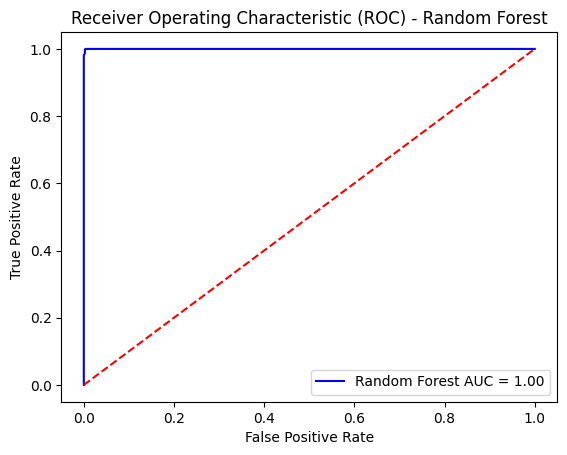

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'Random Forest AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc='lower right')
plt.show()

In [14]:
import pickle
model_path = '/content/drive/MyDrive/rf_steganography_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"Model saved to: {model_path}")

Model saved to: /content/drive/MyDrive/rf_steganography_model.pkl
